In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyiast
import pandas as pd

df_ch4 = pd.read_csv("CH4_isotherm.csv")
df_co2 = pd.read_csv("CO2_isotherm.csv")

In [6]:
import pandas as pd
from ast import literal_eval

# Extraire le dictionnaire
iso_dict = literal_eval(df_ch4[df_ch4["Key"] == "isotherm"]["Value"].values[0])

# Construire un DataFrame avec seulement pression et chargement
df_iso_ch4 = pd.DataFrame({
    "Pressure(bar)": iso_dict["pressure"],
    "Loading(mmol/g)": [val * 1000 for val in iso_dict["loading_absolute_average"]]  # conversion mol/kg → mmol/g
})

print(df_iso_ch4.head())


   Pressure(bar)  Loading(mmol/g)
0            0.2        21.623935
1            0.8        88.216562
2            1.4       159.387230
3            2.0       217.408208
4            2.6       285.007356


In [7]:
import pandas as pd
from ast import literal_eval

# Extraire le dictionnaire
iso_dict = literal_eval(df_co2[df_co2["Key"] == "isotherm"]["Value"].values[0])

# Construire un DataFrame avec seulement pression et chargement
df_iso_co2 = pd.DataFrame({
    "Pressure(bar)": iso_dict["pressure"],
    "Loading(mmol/g)": [val * 1000 for val in iso_dict["loading_absolute_average"]]  # conversion mol/kg → mmol/g
})

print(df_iso_co2.head())

   Pressure(bar)  Loading(mmol/g)
0            0.2       102.794861
1            0.8       396.211524
2            1.4       708.200096
3            2.0      1043.533426
4            2.6      1401.529678


CH4 pressure range: 0.2 to 10.2 bar
CO2 pressure range: 0.2 to 10.2 bar
Using pressure range: 0.1 to 3.9 bar
                      Component 0: p^0 = 10.307556 > 10.200000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 0: p^0 = 10.899738 > 10.200000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.


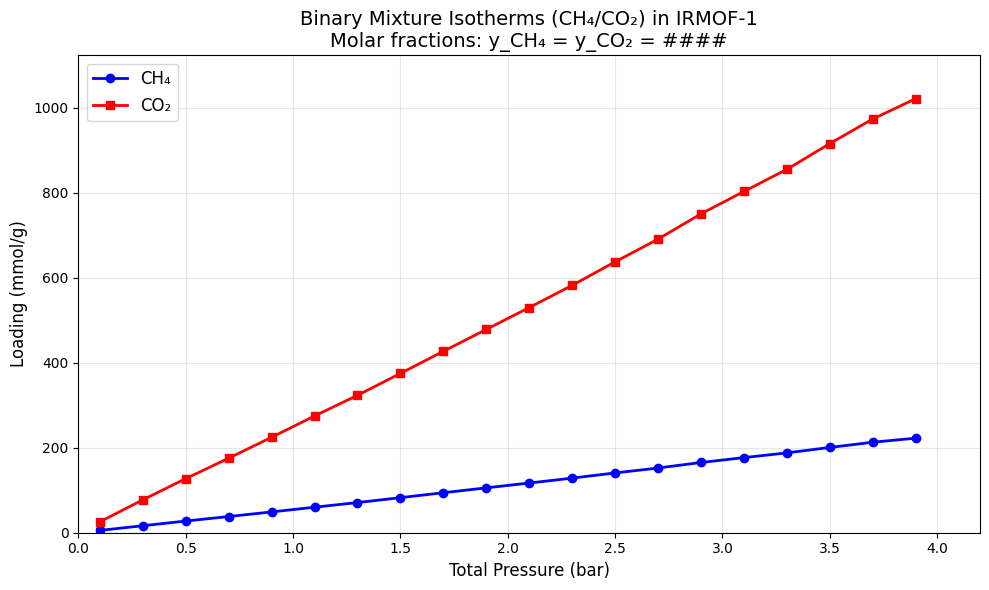


Binary Mixture Isotherm Results:
Pressure (bar)  CH4 Loading     CO2 Loading    
0.1             5.420           25.728         
0.5             27.484          127.276        
0.9             48.868          224.571        
1.3             70.984          323.247        
1.7             94.066          426.690        
2.1             116.907         529.665        
2.5             140.626         637.197        
2.9             165.208         750.120        
3.3             187.783         854.731        
3.7             212.868         973.160        
Total data points calculated: 20


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pyiast
import pandas as pd


# Create isotherms using InterpolatorIsotherm
ch4_isotherm = pyiast.InterpolatorIsotherm(df_iso_ch4,
                                    loading_key="Loading(mmol/g)",
                                    pressure_key="Pressure(bar)",
                                    fill_value=max(df_iso_ch4["Loading(mmol/g)"]))

co2_isotherm = pyiast.InterpolatorIsotherm(df_iso_co2,
                                    loading_key="Loading(mmol/g)",
                                    pressure_key="Pressure(bar)",
                                    fill_value=max(df_iso_ch4["Loading(mmol/g)"]))

# First, let's check the pressure ranges of our data
print("CH4 pressure range:", df_iso_ch4['Pressure(bar)'].min(), "to", df_iso_ch4['Pressure(bar)'].max(), "bar")
print("CO2 pressure range:", df_iso_co2['Pressure(bar)'].min(), "to", df_iso_co2['Pressure(bar)'].max(), "bar")

# Use a more conservative pressure range based on your data
# Start with a smaller range that's well within your data bounds
max_safe_pressure = min(df_iso_ch4['Pressure(bar)'].max(), df_iso_co2['Pressure(bar)'].max()) * 0.8
pressures = np.arange(0.1, 4.1, 0.2)
print(f"Using pressure range: 0.1 to {pressures[-1]:.1f} bar")

# Define molar fractions (0.5 for both components in binary mixture)
y_ch4 = 0.5 # Molar fraction of CH4 in gas phase
y_co2 = 0.5 # Molar fraction of CO2 in gas phase

# Initialize arrays to store results
ch4_loadings = []
co2_loadings = []
successful_pressures = []

# Calculate binary mixture isotherms using IAST
for P_total in pressures:
    try:
        # Partial pressures
        P_ch4 = y_ch4 * P_total
        P_co2 = y_co2 * P_total
        
        # Check if partial pressures are within data range
        if P_ch4 <= df_iso_ch4['Pressure(bar)'].max() and P_co2 <= df_iso_co2['Pressure(bar)'].max():
            # Calculate mixture loadings using IAST
            partial_pressures = [P_ch4, P_co2]
            isotherms = [ch4_isotherm, co2_isotherm]
            
            # Use pyiast.iast to calculate mixture loadings
            q_mix = pyiast.iast(partial_pressures, isotherms, verboseflag=False)
            
            ch4_loadings.append(q_mix[0])  # CH4 loading
            co2_loadings.append(q_mix[1])  # CO2 loading
            successful_pressures.append(P_total)
        else:
            print(f"Skipping pressure {P_total:.1f} bar - outside data range")
            
    except Exception as e:
        print(f"Error at pressure {P_total:.1f} bar: {str(e)[:100]}...")
        continue

# Update pressures to only include successful calculations
pressures = np.array(successful_pressures)

# Convert to numpy arrays for easier handling
ch4_loadings = np.array(ch4_loadings)
co2_loadings = np.array(co2_loadings)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(pressures, ch4_loadings, 'b-', marker='o', linewidth=2, markersize=6, label='CH₄')
plt.plot(pressures, co2_loadings, 'r-', marker='s', linewidth=2, markersize=6, label='CO₂')

plt.xlabel('Total Pressure (bar)', fontsize=12)
plt.ylabel('Loading (mmol/g)', fontsize=12)
plt.title('Binary Mixture Isotherms (CH₄/CO₂) in IRMOF-1\nMolar fractions: y_CH₄ = y_CO₂ = ####', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 4.2)
plt.ylim(0, max(max(ch4_loadings), max(co2_loadings)) * 1.1)

# Add some styling
plt.tight_layout()
plt.show()

# Print some results for verification
print("\nBinary Mixture Isotherm Results:")
print("="*50)
print(f"{'Pressure (bar)':<15} {'CH4 Loading':<15} {'CO2 Loading':<15}")
print("="*50)
for i in range(0, len(pressures), max(1, len(pressures)//8)):  # Print ~8 points
    print(f"{pressures[i]:<15.1f} {ch4_loadings[i]:<15.3f} {co2_loadings[i]:<15.3f}")
print("="*50)
print(f"Total data points calculated: {len(pressures)}")